## Work
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
from sklearn import preprocessing

In [15]:
from keras.regularizers import l1, l2, l1_l2

In [23]:
from keras.layers import Dropout

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
        x = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(x)
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [44]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2]
L1_EXP = [1e-12]
L1_L2_EXP=[1e-12]
drop_ratio=0.25

# l2

In [53]:
def build_mlp(input_shape, output_units=10, num_neurons=[256,128,64], l2_ratio=1e-4,drop_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
            x = Dropout(drop_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
            x = Dropout(drop_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [54]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = L2 %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio,drop_ratio=drop_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = L2 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)

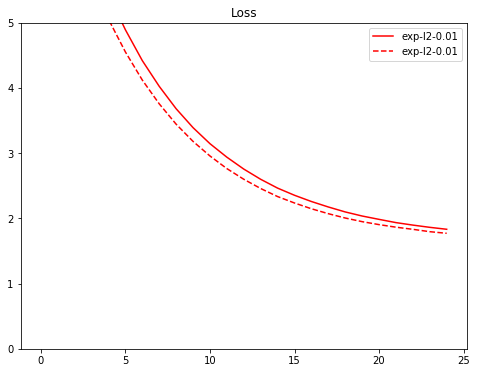

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

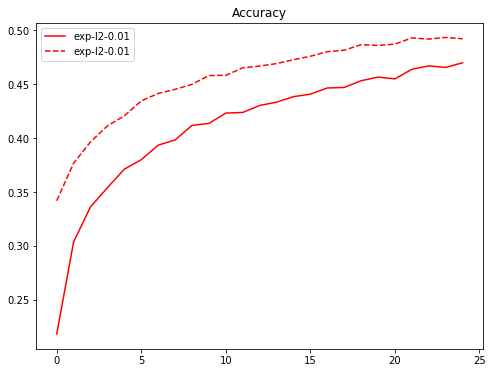

In [56]:
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

# l1

In [57]:
def build_mlp_l1(input_shape, output_units=10, num_neurons=[256,128,64], l1_ratio=1e-4,drop_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
            x = Dropout(drop_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
            x = Dropout(drop_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [58]:
results = {}
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer L1 = %.6f" % (regulizer_ratio))
    model = build_mlp_l1(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio,drop_ratio=drop_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer L1 = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)

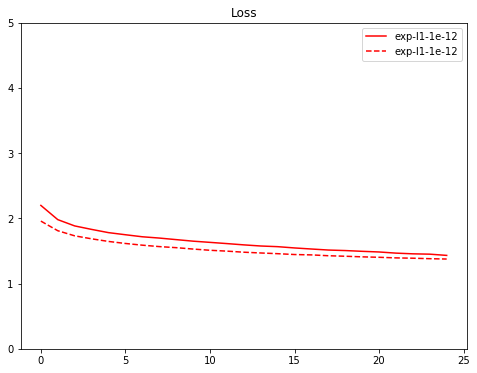

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

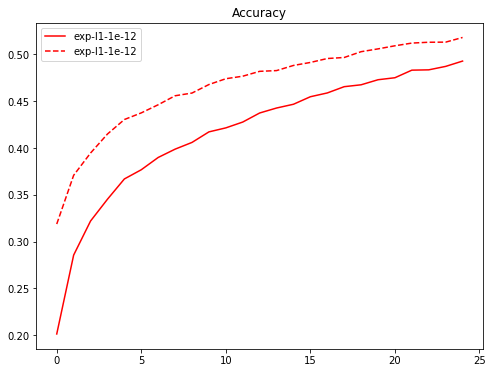

In [60]:
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

# l1_l2

In [61]:
def build_mlp_l1_l2(input_shape, output_units=10, num_neurons=[256,128,64], l1_l2_ratio=1e-4,drop_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(input_layer)
            x = Dropout(drop_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(x)
            x = Dropout(drop_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [62]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
results = {}
for regulizer_ratio in L1_L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer L1_L2 = %.6f" % (regulizer_ratio))
    model = build_mlp_l1_l2(input_shape=x_train.shape[1:], l1_l2_ratio=regulizer_ratio,drop_ratio=drop_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1_l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer L1_L2 = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropo

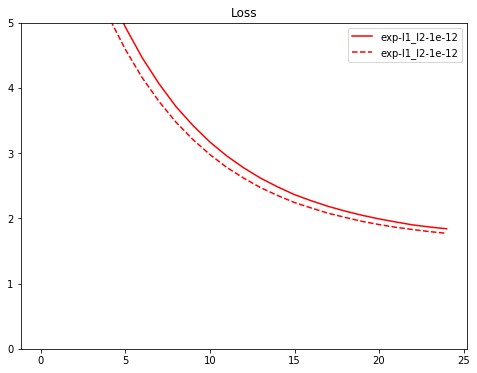

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

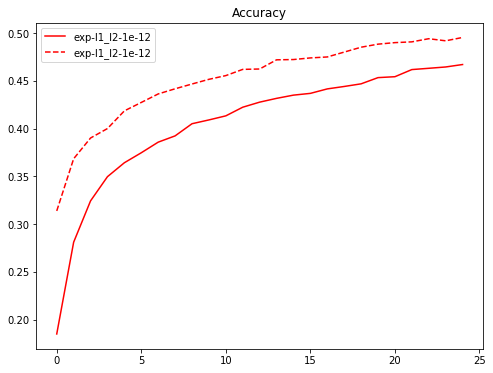

In [64]:
plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()